# lab 1 deteccion de pishing
- Marco Jurado 20308
- Oscar Lopez 20679

## Parte 1 – Ingeniería de características
### Exploración de datos

In [187]:
import pandas as pd
from pandas_profiling import ProfileReport
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


In [188]:
%matplotlib inline

In [189]:
data_set_original = pd.read_csv('dataset_pishing.csv')
data_set_original

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


In [190]:
data_set_original['status'].value_counts()

legitimate    5715
phishing      5715
Name: status, dtype: int64

Podemos observar que el dataset si se encuentra balanceado teniendo exactamente 5715 elementos para legitimate y la misma parte para phishing.

### Preprocesamiento

In [191]:
data_set_original['status'] = data_set_original['status'].map({'legitimate' : 0, 'phishing' : 1})
data_set_original

,url,status
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


In [192]:
# Protocolo
data_set_original['protocol'] = data_set_original['url'].apply(lambda x: 1 if x.startswith('http://') else 0)
data_set_original['protocol'].value_counts()

1    6983
0    4447
Name: protocol, dtype: int64

In [193]:
def check_tld(url):
    accepted_tlds = ['com', 'net', 'org', 'edu', 'gov']
    domain_parts = url.split("//")[-1].split("/")[0]
    found_tld = any(domain_part for domain_part in domain_parts.split('.') if domain_part in accepted_tlds)
    return 0 if found_tld else 1

# Aplicar la función corregida
data_set_original['tld_check'] = data_set_original['url'].apply(check_tld)
data_set_original


,url,status,protocol,tld_check
0,http://www.crestonwood.com/router.php,0,1,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0
2,https://support-appleld.com.secureupdate.duila...,1,0,0
3,http://rgipt.ac.in,0,1,1
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0
...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,1,0
11426,http://www.budgetbots.com/server.php/Server%20...,1,1,0
11427,https://www.facebook.com/Interactive-Televisio...,0,0,0
11428,http://www.mypublicdomainpictures.com/,0,1,0


In [194]:
def tld_repetition(url):
    accepted_tlds = ['.com', '.net', '.org', '.edu', '.gov']
    tld_counts = sum(url.count(tld) for tld in accepted_tlds)
    return 1 if tld_counts > 1 else 0

# Aplicar
data_set_original['tld_repetition'] = data_set_original['url'].apply(tld_repetition)
data_set_original

,url,status,protocol,tld_check,tld_repetition
0,http://www.crestonwood.com/router.php,0,1,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0,0
2,https://support-appleld.com.secureupdate.duila...,1,0,0,1
3,http://rgipt.ac.in,0,1,1,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0
...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,1,0,0
11426,http://www.budgetbots.com/server.php/Server%20...,1,1,0,1
11427,https://www.facebook.com/Interactive-Televisio...,0,0,0,0
11428,http://www.mypublicdomainpictures.com/,0,1,0,0


In [195]:
def long_sld(url):
    domain = url.split("//")[-1].split("/")[0].split('?')[0]
    sld = domain.split('.')[-2] if len(domain.split('.')) > 1 else domain
    threshold = 10
    return 1 if len(sld) > threshold else 0

# Aplicar
data_set_original['long_sld'] = data_set_original['url'].apply(long_sld)
data_set_original

,url,status,protocol,tld_check,tld_repetition,long_sld
0,http://www.crestonwood.com/router.php,0,1,0,0,1
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0,0,1
2,https://support-appleld.com.secureupdate.duila...,1,0,0,1,1
3,http://rgipt.ac.in,0,1,1,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0
...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,1,0,0,0
11426,http://www.budgetbots.com/server.php/Server%20...,1,1,0,1,0
11427,https://www.facebook.com/Interactive-Televisio...,0,0,0,0,0
11428,http://www.mypublicdomainpictures.com/,0,1,0,0,1


In [196]:
def long_path(url):
    parts = url.split('//')
    path = parts[1].split('/', 1)[1] if len(parts) > 1 and '/' in parts[1] else ''
    return 1 if len(path) > 10 else 0

data_set_original['long_path'] = data_set_original['url'].apply(long_path)
data_set_original


,url,status,protocol,tld_check,tld_repetition,long_sld,long_path
0,http://www.crestonwood.com/router.php,0,1,0,0,1,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0,0,1,1
2,https://support-appleld.com.secureupdate.duila...,1,0,0,1,1,1
3,http://rgipt.ac.in,0,1,1,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,1
...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,1,0,0,0,1
11426,http://www.budgetbots.com/server.php/Server%20...,1,1,0,1,0,1
11427,https://www.facebook.com/Interactive-Televisio...,0,0,0,0,0,1
11428,http://www.mypublicdomainpictures.com/,0,1,0,0,1,0


In [197]:
def check_chars_after_tld(url):
    match = re.search(r'https?://([^/]+)/?(.*)', url)
    if match:
        after_tld = match.group(2)
        # Buscar caracteres que no sean alfanuméricos, guiones, puntos o guiones bajos
        if re.search(r'[^a-zA-Z0-9\-._]', after_tld):
            return 1
    return 0

data_set_original['special_chars_after_tld'] = data_set_original['url'].apply(check_chars_after_tld)
data_set_original

,url,status,protocol,tld_check,tld_repetition,long_sld,long_path,special_chars_after_tld
0,http://www.crestonwood.com/router.php,0,1,0,0,1,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0,0,1,1,1
2,https://support-appleld.com.secureupdate.duila...,1,0,0,1,1,1,1
3,http://rgipt.ac.in,0,1,1,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,1,0,0,0,1,1
11426,http://www.budgetbots.com/server.php/Server%20...,1,1,0,1,0,1,1
11427,https://www.facebook.com/Interactive-Televisio...,0,0,0,0,0,1,1
11428,http://www.mypublicdomainpictures.com/,0,1,0,0,1,0,0


### (NUEVAS CARACTERISTICAS)

In [198]:
def multiple_subdomains(url):
    domain_parts = url.split("//")[-1].split("/")[0]
    if domain_parts.count(".") > 1:
        return 1
    return 0

data_set_original['multiple_subdomains'] = data_set_original['url'].apply(multiple_subdomains)


In [199]:
def check_https(url):
    if url.startswith('https://'):
        return 1
    return 0

data_set_original['https'] = data_set_original['url'].apply(check_https)

In [200]:
def url_length(url):
    if len(url) > 75:
        return 1
    return 0

data_set_original['long_url'] = data_set_original['url'].apply(url_length)

In [201]:
def sensitive_keywords(url):
    keywords = ['login', 'verify', 'update', 'auth']
    if any(keyword in url for keyword in keywords):
        return 1
    return 0

data_set_original['sensitive_keywords'] = data_set_original['url'].apply(sensitive_keywords)

In [202]:
def param_count(url):
    parts = url.split('?')
    if len(parts) > 1:
        params = parts[1].split('&')
        return len(params)
    return 0

data_set_original['param_count'] = data_set_original['url'].apply(param_count)

In [203]:
def contains_ip(url):
    return int(bool(re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', url)))

data_set_original['contains_ip'] = data_set_original['url'].apply(contains_ip)


In [204]:
def special_chars_in_domain(url):
    domain = url.split("//")[-1].split("/")[0].split('?')[0]
    return int(bool(re.search(r'[^a-zA-Z0-9\-\.]', domain)))

data_set_original['special_chars_in_domain'] = data_set_original['url'].apply(special_chars_in_domain)


In [205]:
def contains_port(url):
    return int(bool(re.search(r':\d+', url.split("//")[-1].split("/")[0])))

data_set_original['contains_port'] = data_set_original['url'].apply(contains_port)


In [206]:
def url_depth(url):
    path = url.split('://')[-1]
    if '/' in path:
        return path.count('/')
    return 0

data_set_original['url_depth'] = data_set_original['url'].apply(url_depth)


In [207]:
def brand_terms_in_url(url):
    brand_terms = ['paypal', 'microsoft', 'google', 'apple', 'oracle']
    return int(any(term in url for term in brand_terms))

data_set_original['brand_terms_in_url'] = data_set_original['url'].apply(brand_terms_in_url)

In [208]:
data_set_original = data_set_original.drop(columns=['url'])
data_set_original

,status,protocol,tld_check,tld_repetition,long_sld,long_path,special_chars_after_tld,multiple_subdomains,https,long_url,sensitive_keywords,param_count,contains_ip,special_chars_in_domain,contains_port,url_depth,brand_terms_in_url
0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,3,0
2,1,0,0,1,1,1,1,1,1,1,1,3,0,0,0,3,1
3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,2,0
11426,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,3,0
11427,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,3,0
11428,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


Proceso con RandomForestClassifier para poder determinar caracteristicas importantes

In [209]:
X = data_set_original.drop(['status'], axis=1)
y = data_set_original['status']

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importancia']).sort_values('importancia', ascending=False)

print(feature_importances)

# Identificar la característica menos importante
least_important_feature = feature_importances.idxmin()[0]
print(f"La característica menos importante es: {least_important_feature}")


                         importancia
url_depth                   0.192030
sensitive_keywords          0.141019
param_count                 0.137199
multiple_subdomains         0.105355
tld_check                   0.076420
long_url                    0.064331
long_sld                    0.051908
brand_terms_in_url          0.051480
long_path                   0.047208
tld_repetition              0.043165
special_chars_after_tld     0.026758
protocol                    0.024510
https                       0.023643
contains_ip                 0.011316
special_chars_in_domain     0.002201
contains_port               0.001457
La característica menos importante es: contains_port


### Visualización de resultados

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 268.59it/s]


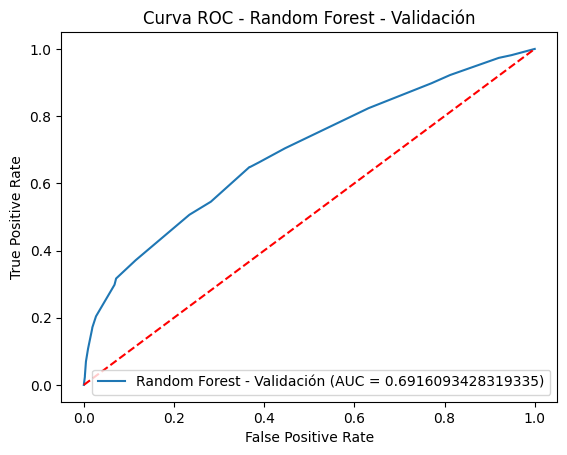

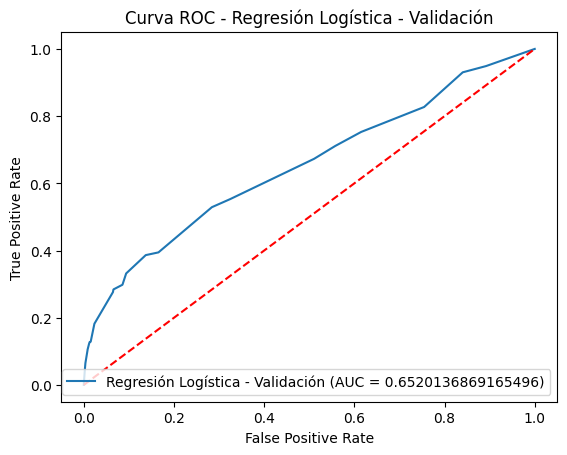

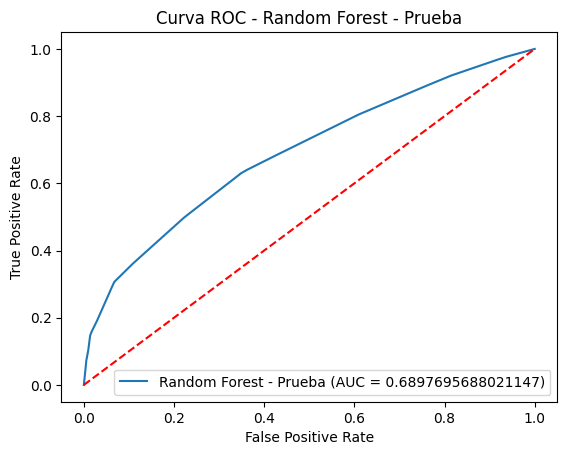

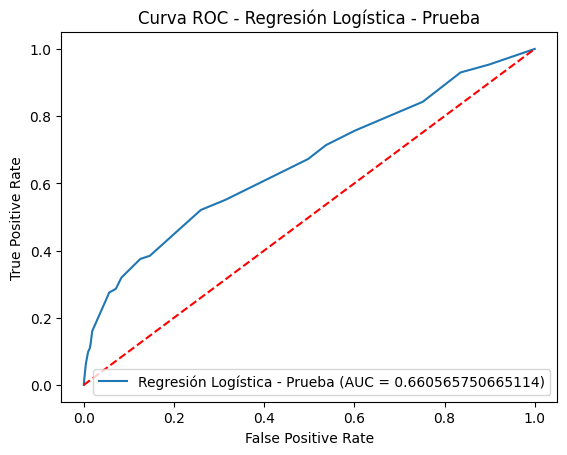

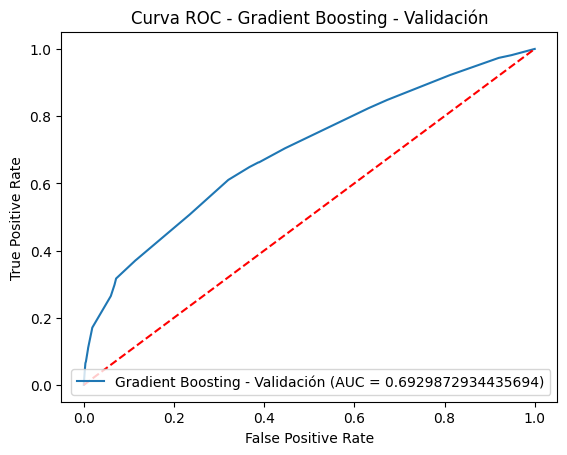

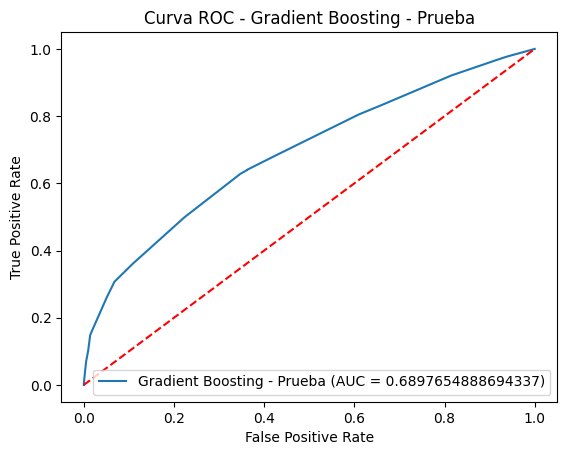

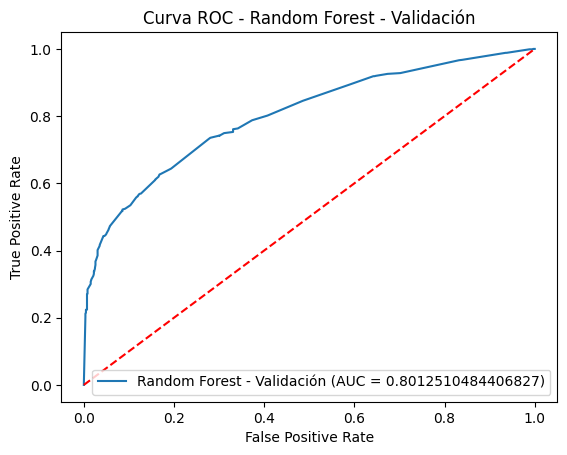

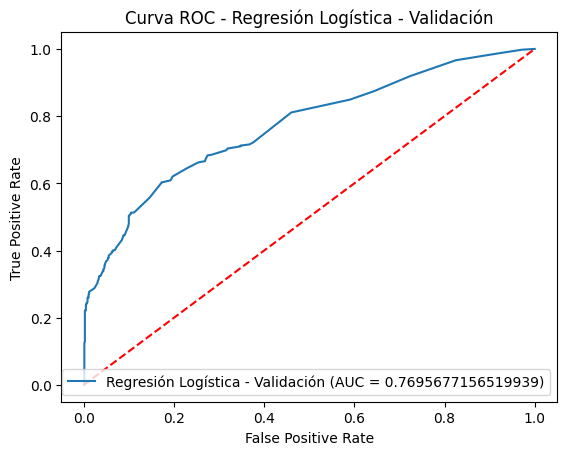

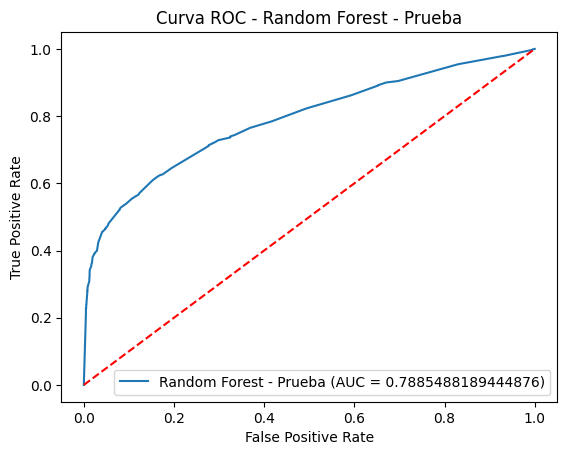

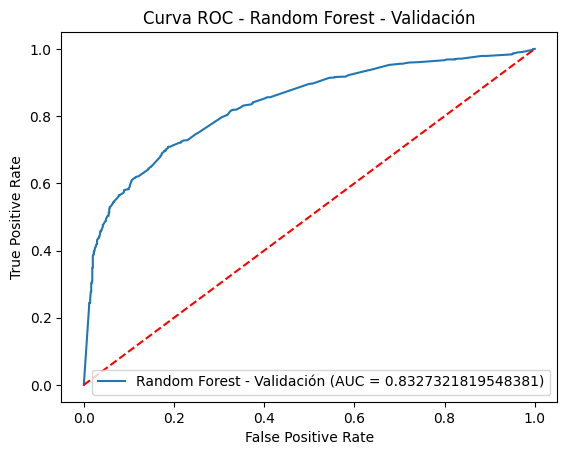

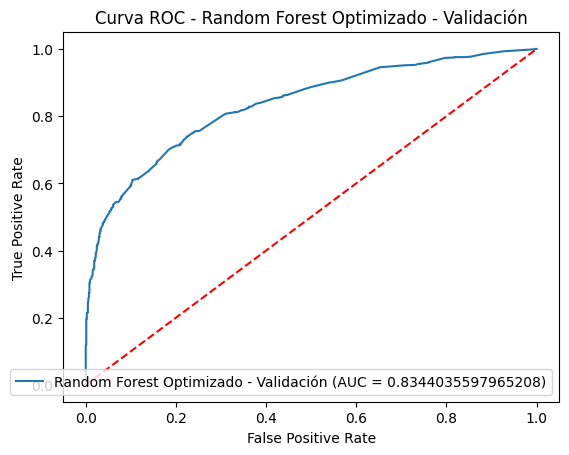

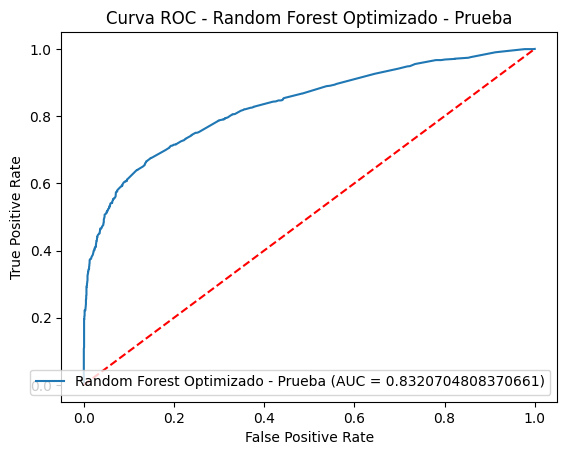

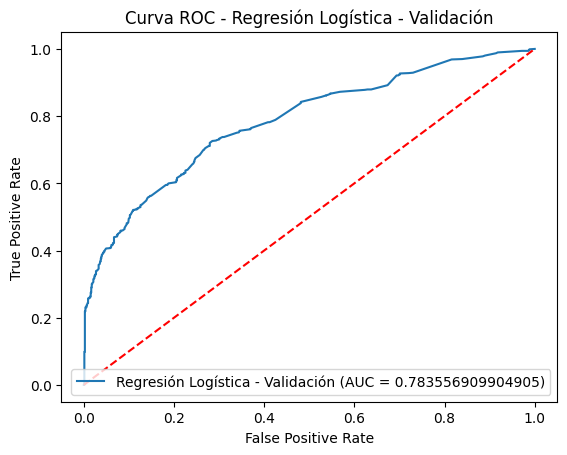

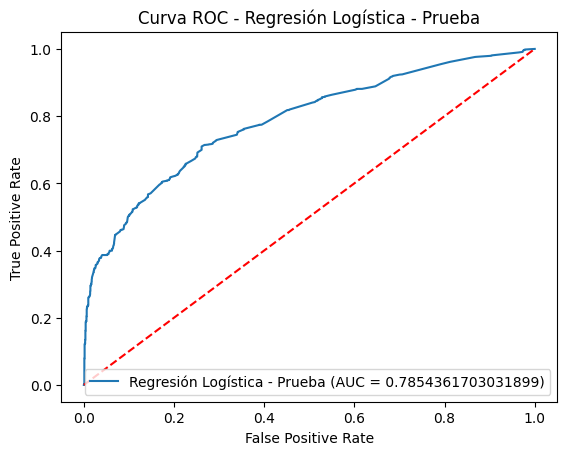

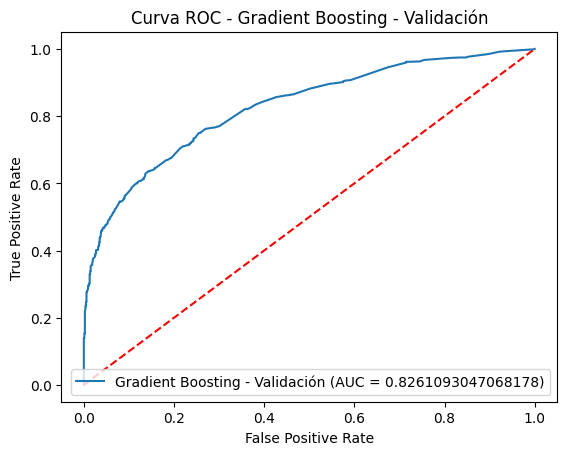

In [210]:
profile = ProfileReport(data_set_original, title="Analisis de Modelo de Deteccion de Phishing", explorative=True)
profile.to_file("analisis_modelo_phishing.html")

### Selección de Características
Al observar podemos ver que special_chars_after_tld tiene mucha correlacion con long_path por lo tanto es probable que también se encuentren caracteres especiales a medida que haya un path largo por lo tanto sera eliminada.<br><br>
(NUEVO)<br>
Tras hacer un proceso con RandomForestClassifier podemos ver que adicionalmente estaremos eliminando las nuevas caracteristicas generadas que estan debajo del rating obtenido de 0.02

In [211]:
data_set_original = data_set_original.drop(columns=['special_chars_after_tld', 'contains_ip', 'special_chars_in_domain', 'contains_port'])
data_set_original

,status,protocol,tld_check,tld_repetition,long_sld,long_path,multiple_subdomains,https,long_url,sensitive_keywords,param_count,url_depth,brand_terms_in_url
0,0,1,0,0,1,0,1,0,0,0,0,1,0
1,1,1,0,0,1,1,0,0,1,0,0,3,0
2,1,0,0,1,1,1,1,1,1,1,3,3,1
3,0,1,1,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,1,1,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,1,0,0,0,1,1,0,0,0,0,2,0
11426,1,1,0,1,0,1,1,0,1,1,1,3,0
11427,0,0,0,0,0,1,1,1,1,0,1,3,0
11428,0,1,0,0,1,0,1,0,0,0,0,1,0


## Parte 2 – Implementación
### Separación de datos

In [212]:
train_df, temp_df = train_test_split(data_set_original, test_size=0.45, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

train_file_path = 'train_dataset.csv'
validation_file_path = 'validation_dataset.csv'
test_file_path = 'test_dataset.csv'

train_df.to_csv(train_file_path, index=False)
validation_df.to_csv(validation_file_path, index=False)
test_df.to_csv(test_file_path, index=False)

train_file_path, validation_file_path, test_file_path

('train_dataset.csv', 'validation_dataset.csv', 'test_dataset.csv')

### Implementación

In [213]:
train_df = pd.read_csv('train_dataset.csv')
validation_df = pd.read_csv('validation_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train = train_df.drop('status', axis=1)
y_train = train_df['status']
X_validation = validation_df.drop('status', axis=1)
y_validation = validation_df['status']
X_test = test_df.drop('status', axis=1)
y_test = test_df['status']

In [214]:
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    # Métricas
    conf_mat = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    auc_score = roc_auc_score(y, y_proba)
    fpr, tpr, _ = roc_curve(y, y_proba)

    # Mostrar resultados
    print(f'{name} - Matriz de Confusión:\n{conf_mat}')
    print(f'{name} - Precisión: {precision}')
    print(f'{name} - Recall: {recall}')
    print(f'{name} - AUC: {auc_score}')

    # Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc='lower right')
    plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits


Mejores hiperparámetros:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor score AUC:  0.8263393908337313
Random Forest Optimizado - Validación - Matriz de Confusión:
[[717 135]
 [288 574]]
Random Forest Optimizado - Validación - Precisión: 0.8095909732016925
Random Forest Optimizado - Validación - Recall: 0.665893271461717
Random Forest Optimizado - Validación - AUC: 0.8344035597965208


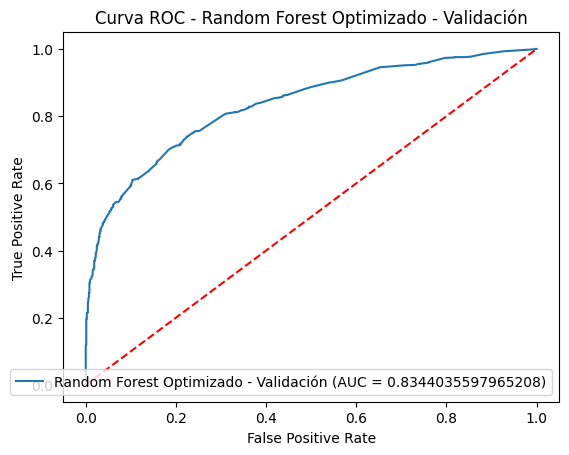

Random Forest Optimizado - Prueba - Matriz de Confusión:
[[1478  237]
 [ 577 1138]]
Random Forest Optimizado - Prueba - Precisión: 0.8276363636363636
Random Forest Optimizado - Prueba - Recall: 0.6635568513119533
Random Forest Optimizado - Prueba - AUC: 0.8320704808370661


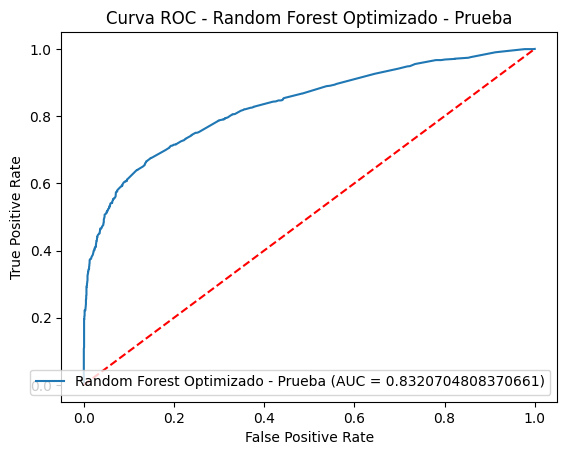

In [215]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("Mejores hiperparámetros: ", grid_search_rf.best_params_)
print("Mejor score AUC: ", grid_search_rf.best_score_)

best_rf_model = grid_search_rf.best_estimator_
evaluate_model(best_rf_model, X_validation, y_validation, 'Random Forest Optimizado - Validación')
evaluate_model(best_rf_model, X_test, y_test, 'Random Forest Optimizado - Prueba')

(NUEVO)

Matriz de Confusión:

Esta matriz nos proporciona una visión de cómo el modelo Random Forest ha clasificado las muestras:
- 1478 verdaderos negativos (TN): el modelo clasificó correctamente 1478 URL legítimas.
- 237 falsos positivos (FP): el modelo clasificó erróneamente 237 URL legítimas como phishing.
- 577 falsos negativos (FN): el modelo clasificó erróneamente 577 URL de phishing como legítimas.
- 1138 verdaderos positivos (TP): el modelo clasificó correctamente 1138 URL de phishing.

Precisión:
La precisión del modelo es del 82.8%. Esto significa que, de todas las URL que el modelo clasificó como phishing, el 82.8% eran realmente phishing. Es una medida de la exactitud de las predicciones positivas del modelo.

Recall:
El recall del modelo es del 66.4%. Esto indica que el modelo identificó correctamente el 66.4% de todas las URL de phishing en el conjunto de datos. Es una medida de la capacidad del modelo para encontrar todas las muestras positivas.

AUC:
El AUC del modelo es del 83.2%. Esta métrica representa la capacidad del modelo para distinguir entre las clases positiva y negativa. Cuanto más alto sea el valor, mejor es el rendimiento del modelo. En este caso, un AUC de 0.832 sugiere que el modelo tiene una buena capacidad para discriminar entre URLs legítimas y de phishing.

En resumen, el modelo Random Forest optimizado tiene una precisión del 82.8%, un recall del 66.4% y un AUC del 83.2%. Estos resultados muestran un rendimiento bastante bueno del modelo en la detección de URLs de phishing. Sin embargo, al igual que con los otros modelos, aún existe un balance entre falsos positivos y falsos negativos que podría requerir ajustes adicionales dependiendo de los requisitos específicos del problema.

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Mejores hiperparámetros:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor score AUC:  0.7818868243984589
Regresión Logística Optimizada - Validación - Matriz de Confusión:
[[676 176]
 [331 531]]
Regresión Logística Optimizada - Validación - Precisión: 0.751060820367751
Regresión Logística Optimizada - Validación - Recall: 0.6160092807424594
Regresión Logística Optimizada - Validación - AUC: 0.7836508610829711


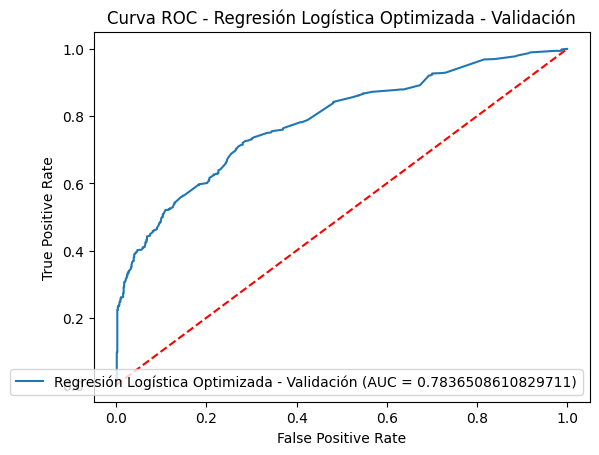

Regresión Logística Optimizada - Prueba - Matriz de Confusión:
[[1384  331]
 [ 657 1058]]
Regresión Logística Optimizada - Prueba - Precisión: 0.761699064074874
Regresión Logística Optimizada - Prueba - Recall: 0.6169096209912537
Regresión Logística Optimizada - Prueba - AUC: 0.7854031908473511


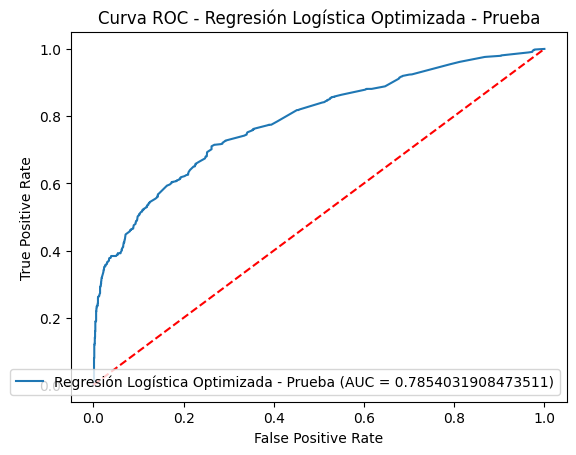

In [216]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train, y_train)

print("Mejores hiperparámetros: ", grid_search_lr.best_params_)
print("Mejor score AUC: ", grid_search_lr.best_score_)

best_lr_model = grid_search_lr.best_estimator_
evaluate_model(best_lr_model, X_validation, y_validation, 'Regresión Logística Optimizada - Validación')
evaluate_model(best_lr_model, X_test, y_test, 'Regresión Logística Optimizada - Prueba')

(NUEVO)

Matriz de Confusión:

Esta matriz nos muestra cómo el modelo de Regresión Logística ha clasificado las muestras:
- 1384 verdaderos negativos (TN): el modelo clasificó correctamente 1384 URL legítimas.
- 331 falsos positivos (FP): el modelo clasificó erróneamente 331 URL legítimas como phishing.
- 657 falsos negativos (FN): el modelo clasificó erróneamente 657 URL de phishing como legítimas.
- 1058 verdaderos positivos (TP): el modelo clasificó correctamente 1058 URL de phishing.

Precisión:
La precisión del modelo es del 76.2%. Esto significa que, de todas las URL que el modelo clasificó como phishing, el 76.2% eran realmente phishing. Es una medida de la exactitud de las predicciones positivas del modelo.

Recall:
El recall del modelo es del 61.7%. Esto indica que el modelo identificó correctamente el 61.7% de todas las URL de phishing en el conjunto de datos. Es una medida de la capacidad del modelo para encontrar todas las muestras positivas.

AUC:
El AUC del modelo es del 78.5%. Esta métrica representa la capacidad del modelo para distinguir entre las clases positiva y negativa. Un valor más alto indica un mejor rendimiento del modelo en general. Un AUC de 0.785 sugiere que el modelo tiene una buena capacidad para discriminar entre URLs legítimas y de phishing.

En resumen, el modelo de Regresión Logística optimizado tiene una precisión del 76.2%, un recall del 61.7% y un AUC del 78.5%. Estos resultados muestran un rendimiento decente del modelo en la detección de URLs de phishing. Sin embargo, al igual que con los otros modelos, aún existe un balance entre falsos positivos y falsos negativos que podría requerir ajustes adicionales dependiendo de los requisitos específicos del problema.

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Mejores hiperparámetros:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
Mejor score AUC:  0.828889781208361
Gradient Boosting Optimizado - Validación - Matriz de Confusión:
[[688 164]
 [254 608]]
Gradient Boosting Optimizado - Validación - Precisión: 0.7875647668393783
Gradient Boosting Optimizado - Validación - Recall: 0.7053364269141531
Gradient Boosting Optimizado - Validación - AUC: 0.8345070422535212


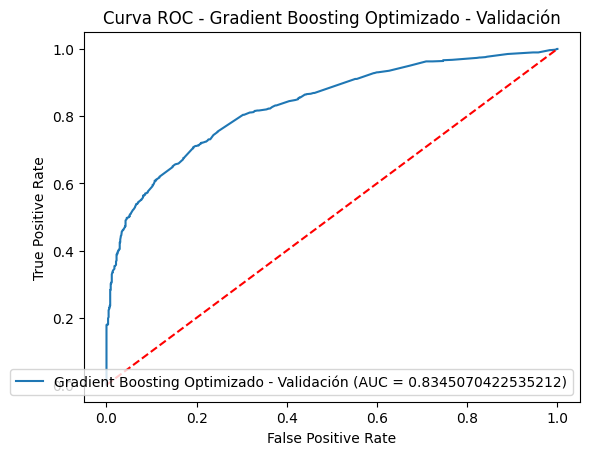

Gradient Boosting Optimizado - Prueba - Matriz de Confusión:
[[1385  330]
 [ 508 1207]]
Gradient Boosting Optimizado - Prueba - Precisión: 0.7852960312296682
Gradient Boosting Optimizado - Prueba - Recall: 0.7037900874635569
Gradient Boosting Optimizado - Prueba - AUC: 0.8312847538015623


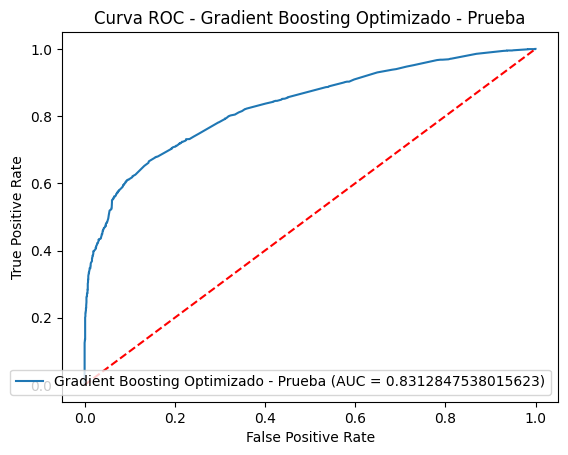

In [217]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)

print("Mejores hiperparámetros: ", grid_search_gb.best_params_)
print("Mejor score AUC: ", grid_search_gb.best_score_)

best_gb_model = grid_search_gb.best_estimator_
evaluate_model(best_gb_model, X_validation, y_validation, 'Gradient Boosting Optimizado - Validación')
evaluate_model(best_gb_model, X_test, y_test, 'Gradient Boosting Optimizado - Prueba')


(NUEVO)

Matriz de Confusión:

Esta matriz nos muestra cómo nuestro modelo de Gradient Boosting ha clasificado las muestras. Tenemos:
- 1385 verdaderos negativos (TN): el modelo clasificó correctamente 1385 URL legítimas.
- 330 falsos positivos (FP): el modelo clasificó erróneamente 330 URL legítimas como phishing.
- 508 falsos negativos (FN): el modelo clasificó erróneamente 508 URL de phishing como legítimas.
- 1207 verdaderos positivos (TP): el modelo clasificó correctamente 1207 URL de phishing.

Precisión:
La precisión del modelo es del 78.5%. Esto significa que de todas las URL que el modelo clasificó como phishing, el 78.5% eran realmente phishing. Es una medida de la exactitud de las predicciones positivas del modelo.

Recall:
El recall del modelo es del 70.4%. Esto indica que el modelo identificó correctamente el 70.4% de todas las URL de phishing en el conjunto de datos. Es una medida de la capacidad del modelo para encontrar todas las muestras positivas.

AUC:
El AUC del modelo es del 83.1%. Esta métrica representa la capacidad del modelo para distinguir entre las clases positiva y negativa. Cuanto más alto sea el valor, mejor es el rendimiento del modelo. En este caso, 0.83 es un valor bastante bueno, lo que indica que el modelo tiene una buena capacidad para discriminar entre URLs legítimas y de phishing.

En resumen, el modelo de Gradient Boosting optimizado tiene una precisión del 78.5%, un recall del 70.4% y un AUC del 83.1%. Estos resultados sugieren que el modelo tiene un buen rendimiento en la detección de URLs de phishing, aunque hay un número significativo de falsos positivos y falsos negativos que podrían mejorarse con ajustes adicionales en el modelo o en los datos de entrada.

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores hiperparámetros:  {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Mejor score AUC:  0.8017354376794638
SVC Optimizado - Validación - Matriz de Confusión:
[[746 106]
 [370 492]]
SVC Optimizado - Validación - Precisión: 0.822742474916388
SVC Optimizado - Validación - Recall: 0.5707656612529002
SVC Optimizado - Validación - AUC: 0.7962294260536147


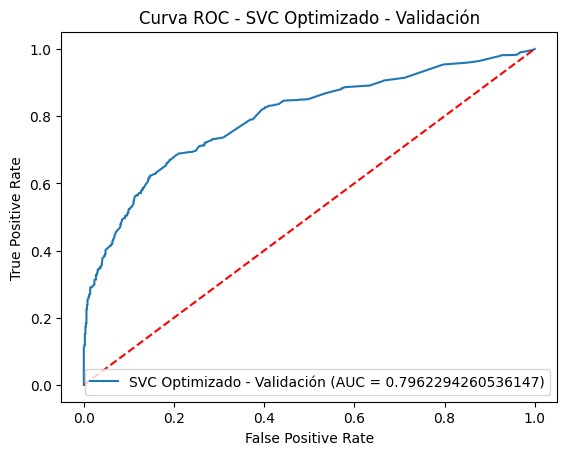

SVC Optimizado - Prueba - Matriz de Confusión:
[[1538  177]
 [ 750  965]]
SVC Optimizado - Prueba - Precisión: 0.8450087565674256
SVC Optimizado - Prueba - Recall: 0.5626822157434402
SVC Optimizado - Prueba - AUC: 0.796587986298226


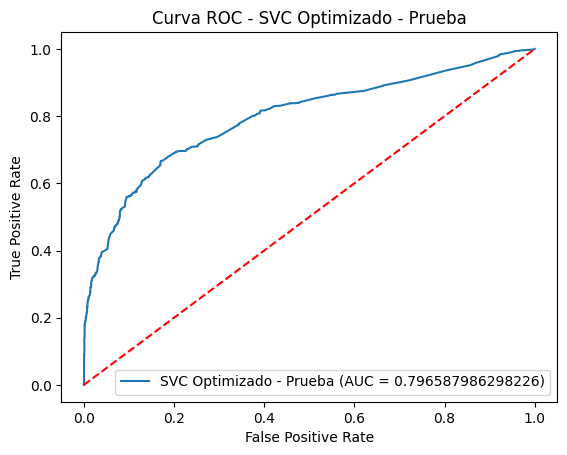

In [218]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

grid_search_svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svc, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_svc.fit(X_train, y_train)

print("Mejores hiperparámetros: ", grid_search_svc.best_params_)
print("Mejor score AUC: ", grid_search_svc.best_score_)

best_svc_model = grid_search_svc.best_estimator_
evaluate_model(best_svc_model, X_validation, y_validation, 'SVC Optimizado - Validación')
evaluate_model(best_svc_model, X_test, y_test, 'SVC Optimizado - Prueba')

(NUEVO)

Matriz de Confusión:

Esta matriz muestra cómo el modelo de Support Vector Classifier (SVC) ha clasificado las muestras:
- 1538 verdaderos negativos (TN): el modelo clasificó correctamente 1538 URL legítimas.
- 177 falsos positivos (FP): el modelo clasificó erróneamente 177 URL legítimas como phishing.
- 750 falsos negativos (FN): el modelo clasificó erróneamente 750 URL de phishing como legítimas.
- 965 verdaderos positivos (TP): el modelo clasificó correctamente 965 URL de phishing.

Precisión:
La precisión del modelo es del 84.5%. Esto significa que, de todas las URL que el modelo clasificó como phishing, el 84.5% eran realmente phishing. Es una medida de la exactitud de las predicciones positivas del modelo.

Recall:
El recall del modelo es del 56.3%. Esto indica que el modelo identificó correctamente el 56.3% de todas las URL de phishing en el conjunto de datos. Es una medida de la capacidad del modelo para encontrar todas las muestras positivas.

AUC:
El AUC del modelo es del 79.7%. Esta métrica representa la capacidad del modelo para distinguir entre las clases positiva y negativa. Un valor más alto indica un mejor rendimiento del modelo en general. Un valor de 0.797 es bastante decente y sugiere que el modelo tiene una buena capacidad para distinguir entre URLs legítimas y de phishing.

En resumen, el modelo SVC optimizado tiene una precisión del 84.5%, un recall del 56.3% y un AUC del 79.7%. Aunque la precisión es alta, el recall es relativamente bajo en comparación con el modelo de Gradient Boosting. Esto sugiere que el modelo de SVC puede estar clasificando más URLs legítimas correctamente, pero está perdiendo más URLs de phishing. Dependiendo de los requisitos específicos del problema, este rendimiento podría ser aceptable o podrían ser necesarios ajustes adicionales para mejorar la detección de URLs de phishing.

# Preguntas

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?

R// En este caso el análisis de la URL agiliza el proceso de conocimiento si un sitio al que se puede ingresar es Phishing o probable de serlo. Esto debido a que para realizar este análisis se pueden usar modelod y características previamente conocidas sobre los sitios peligrosos. Esto llevando a evitar realizar un análisis mayormente exhaustivo y logrando así la detección temprana del sitio. <br> <br>
(NUEVO)<br>
Otra ventaja del análisis de URL es su capacidad para detectar rápidamente tácticas, como faltas de ortografía o el uso de marcas legítimas de forma engañosa. Un ejemplo de esto es app1e en lugar de apple donde el uso del numero 1 en lugar de la letra "l" es usado para engañar al cibernauta.Esto permite una identificación eficiente de posibles amenazas de phishing sin necesidad de análisis más profundos.

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

R// En este caso para el análisis de la URL las características mayormente importantes para lograr conocer y realizar la detección del Phishing, pueden ser:
- La longitud que puede tener la URL
- El dominio que puede tener esta URL
- Los caracteres que pueden estar involucrados en la URL
- El protocolo que tiene la URL
<br><br>
(NUEVO) <br>
* Tiene dirección IP?: Si la URL usa una IP directa, ¡ojo!
* ¿Hay archivo .exe?: Los .exe en URLs pueden ser mala señal.
* Palabras sospechosas: ¿Ves "login" o "bank"? Algo raro pasa.
* Redirecciones raras: Ese "//" podría llevar a lugares no deseados.
* Enlaces dentro de enlaces: Complicado y sospechoso.
* Dominio joven: Si es muy nuevo, podría ser un dominio trampa.
* ¿Qué puerto usa?: HTTPS es común, pero hay que estar alertas.
* Demasiados guiones: Imitar nombres de sitios legítimos es su juego.
* Símbolo "@": No es normal encontrarlo en una URL.
* Muchos puntos: Puede ser un intento de esconder algo.
* Entropía rara: Los caracteres extraños distribuidos de manera rara, alerta.
* Hosting gratuito: Algunos phishers usan estos servicios.
* Caracteres especiales: "#", "$", "&", etc., pueden ser señales.
* Codificación %: Esos %20 o similares, pueden ser trucos.
* Caracteres seleccionados: Fíjate si usan "/", "?", ".", "_", "-", "=", "&", ";", "@", "%".

3. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?

R// Al momento de tener esta acción el impacto sobre la página que se determina como phishing sería muy negativo, debido a que al momento de determinar el caso contrario al que es, esta página perdería la confianza de los usuarios a los cuáles podría llegar a cautivar. En el caso del sistema esto puede generar una pérdida de confianza para los usuarios que conozcan la realidad sobre el sitio que ha sido mal clasificado.

4. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

R// Principalmente esto presenta una falla de seguridad debido a que las personas que no tengan el conocimiento y confien en el sistema pueden llegar a ser víctimas de la ciberdelincuencia que pueden brindar estos sitios maliciosos, debido a esto muchas personas pueden perder la completa confianza en el sistema e indicar que no sirve de manera correcta.

5. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares
de clasificación de phishing?

R// En este caso la mejor métrica para realizar la comparación de los modelos puede ser la precisión debido a que los modelos deben de ser lo más precisos posibles ya que cualquier falla entre ellos puede causar repercusiones grandes en el uso que puede tener cada uno de estos. Otra muy importante puede ser el recall debido a que esta pueden indicar la cantidad de verdaderos sitios que son phishing con respecto a los sitios existentes. Por esto estas dos métricas son muy importantes para conocer el mejor modelo de clasificación.

6. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

R// En este caso realizando la comparación entre las distintas métricas de desempeño que tienen los modelos probados con la información se puede conocer que el modelo de Gradient Boosting fue el que mejor rendimiento tuvo a comparación de todos los otros, debido a la cantidad más alta a comparación de las métricas de prueba de los otros modelos.

7. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes
ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails,
un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y
cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué se
podría hacer para reducir la cantidad de falsas alarmas?

Cantidad de emails phishing = 7500
7500 * 69% = 5175 alarmas que genera el modelo

De las 5175 alarmas el modelo generaría:
- 3572 alarmas verdaderas positivas
- 1603 alarmas falsas negativas

En este caso el modelo no funcionaría de mejor manera correcta, debido a que existe un rango algo amplio de falla del modelo y que se puedan dar casos en los que los empleados de la empresa sufran de phishing.

Para mejorar el modelo y reducir la cantidad de falsas alarmas se puede mejorar con respecto a elegir otras características en el modelo o elegir más características que puedan ser relevantes para el análisis de la URL, además se puede buscar otros modelos que puedan manejar de mejor manera la clasificación de la data. 